In [6]:
#%pip install -q git+https://github.com/keras-team/keras-nlp.git --upgrade


Note: you may need to restart the kernel to use updated packages.


In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [8]:
import pandas as pd
import json

from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input, Model, Sequential, regularizers
from tensorflow.keras.layers import concatenate,TimeDistributed, Concatenate, GRU, Activation, SpatialDropout2D, Dropout, Flatten,SeparableConv1D, Dense, SimpleRNN, LSTM, Conv1D, Reshape,MaxPooling1D, Conv2D, Reshape,MaxPooling2D, Permute,Bidirectional, BatchNormalization, DepthwiseConv2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,Callback#training callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import models
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from ast import literal_eval

import matplotlib.pyplot as plt
import numpy as np


In [9]:
#from google.colab import drive
#drive.mount('/content/drive')

In [10]:
folder_path = './'

In [11]:
data_path = folder_path + 'data-set-rows.json'
import codecs

with codecs.open(data_path, "r", "utf_8_sig") as data_file:
  data_text = data_file.read()  
  # убираем BOM-символ из json файла
  data = json.loads(data_text.lstrip('\ufeff'))
  df = pd.DataFrame(data)

print('Total rows:', len(df))
print('Duplicates:', sum(df["TextLine"].duplicated()))

Total rows: 2043
Duplicates: 415


drop duplicates

In [12]:
df = df[~df["TextLine"].duplicated()]
print('Deduplicated rows:', len(df))

Deduplicated rows: 1628


In [13]:
#print(df.info)
print(df.shape)
print(df.columns.values)
print(df.head(20))

(1628, 2)
['TextLine' 'Parameters']
                                             TextLine Parameters
0                              пневмония, КТ-2, ДН 0         [0]
2   дыхание, першение в горле, головная боль, одыш...        [0]
3   Жалобы: слабость общая умеренная, сухой со сви...        [0]
4   Жалобы: слабость общая умеренная, сухой, одышк...        [0]
5   Жалобы: слабость общая умеренная, сухой, одышк...        [0]
6   Жалобы: слабость общая умеренная,кашель сухой,...        [0]
7   Лейкоциты (WBC) 11.56 10Е9/л (3.80 - 11.80) Ли...        [1]
8   10Е9/л (1.70 - 7.60) Базофилы # (Bas) 0.04 10Е...         []
11  Лейкоциты (WBC) 14.32 10Е9/л (3.80 - 11.80) Ли...        [1]
13                         одышка при фн выраженная.         [0]
14  одышка при фн выраженная, к ночи чувство распи...        [0]
15  одышка в покое, к ночи чувство распирание в го...        [0]
16  одышка в покое, не может спать на животе ввиду...        [0]
18  Лейкоциты (WBC) 9.23 10Е9/л (3.80 - 11.80) Лим... 

In [14]:
#change labeling style
for i in range(len(df)):
  #нет параметров
  if (df.iloc[i]['Parameters'])==[]:
    df.iloc[i]['Parameters']=0
  #одышка при фн
  if (df.iloc[i]['Parameters'])==[0]:
    df.iloc[i]['Parameters']=1
  #лимфоциты абс
  if (df.iloc[i]['Parameters'])==[1]:
    df.iloc[i]['Parameters']=2



In [15]:
#print(df.info)
print(df.shape)
print(df.columns.values)
print(df.head(20))

(1628, 2)
['TextLine' 'Parameters']
                                             TextLine Parameters
0                              пневмония, КТ-2, ДН 0           1
2   дыхание, першение в горле, головная боль, одыш...          1
3   Жалобы: слабость общая умеренная, сухой со сви...          1
4   Жалобы: слабость общая умеренная, сухой, одышк...          1
5   Жалобы: слабость общая умеренная, сухой, одышк...          1
6   Жалобы: слабость общая умеренная,кашель сухой,...          1
7   Лейкоциты (WBC) 11.56 10Е9/л (3.80 - 11.80) Ли...          2
8   10Е9/л (1.70 - 7.60) Базофилы # (Bas) 0.04 10Е...          0
11  Лейкоциты (WBC) 14.32 10Е9/л (3.80 - 11.80) Ли...          2
13                         одышка при фн выраженная.           1
14  одышка при фн выраженная, к ночи чувство распи...          1
15  одышка в покое, к ночи чувство распирание в го...          1
16  одышка в покое, не может спать на животе ввиду...          1
18  Лейкоциты (WBC) 9.23 10Е9/л (3.80 - 11.80) Лим... 

In [16]:
#print values
def get_classes_counts(data, classes_num):
  for i in range(classes_num):
    class_count = len(list(filter(lambda x: x == i, data)))
    print("Class ", i, " = ", class_count)

In [17]:
#preprocess the data
import re
to_exclude = '»«$&()*+-/<=>@[\\]^_`{|}~\t\n'#excluded symbols
to_tokenize = '.,:!?";%#'#processed symbols

data_length = len(df.index)

for i in range(data_length):
    df.iloc[i]["TextLine"]=re.sub(r'(['+to_tokenize+'])', r' \1 ', df.iloc[i]['TextLine'])

    if i%100==0:
      print(df.iloc[i])

TextLine        пневмония ,  КТ-2 ,  ДН 0 
Parameters                               1
Name: 0, dtype: object
TextLine      гемоглобина (MCHC) 310 . 00 г/л (323 . 00 - 35...
Parameters                                                    2
Name: 112, dtype: object
TextLine      Основной :  Коронавирусная инфекция ,  вызванн...
Parameters                                                    0
Name: 218, dtype: object
TextLine       Жалобы :  кашель малопродуктивный .  боль в н...
Parameters                                                    0
Name: 338, dtype: object
TextLine       Доступные и значимые данные лабораторных и ин...
Parameters                                                    0
Name: 446, dtype: object
TextLine      На протяжении обоих легких участки уплотнения ...
Parameters                                                    1
Name: 567, dtype: object
TextLine      Диагноз :  Основное заболевание Короновирусная...
Parameters                                                    

In [18]:
text_subframe = df["TextLine"]
max_len = 50
num_words = 6000

tokenizer_text = Tokenizer(num_words=num_words, filters=to_exclude, oov_token='UNK')

tokenizer_text.fit_on_texts(text_subframe)

tokenizer_text.word_index


{'UNK': 1,
 '.': 2,
 ',': 3,
 'в': 4,
 '00': 5,
 'л': 6,
 '0': 7,
 ':': 8,
 '%': 9,
 'на': 10,
 ';': 11,
 '3': 12,
 '1': 13,
 '10': 14,
 'мин': 15,
 '2': 16,
 'при': 17,
 'с': 18,
 '10е9': 19,
 'не': 20,
 '4': 21,
 'сатурация': 22,
 'одышка': 23,
 'ст': 24,
 '20': 25,
 '5': 26,
 'дыхание': 27,
 '50': 28,
 'хрипы': 29,
 '80': 30,
 'и': 31,
 '#': 32,
 '11': 33,
 'кислорода': 34,
 'чд': 35,
 'пневмония': 36,
 'дн': 37,
 'нет': 38,
 'г': 39,
 'мм': 40,
 '19': 41,
 'по': 42,
 '2021': 43,
 'лимфоциты': 44,
 'двусторонняя': 45,
 'фн': 46,
 '70': 47,
 '7': 48,
 'жалобы': 49,
 'дыхания': 50,
 '30': 51,
 'кислороде': 52,
 'нагрузке': 53,
 'воздухе': 54,
 'акте': 55,
 '12': 56,
 'во': 57,
 'кт': 58,
 '36': 59,
 'внебольничная': 60,
 '40': 61,
 'вспомогательная': 62,
 'участвует': 63,
 'мускулатура': 64,
 '90': 65,
 'отделы': 66,
 'все': 67,
 'проводится': 68,
 'от': 69,
 'вирусная': 70,
 'состояние': 71,
 '60': 72,
 '21': 73,
 'лейкоциты': 74,
 'увлажненном': 75,
 '8': 76,
 'сидя': 77,
 'инфекция

In [19]:
#create sequenses
sequences_text = tokenizer_text.texts_to_sequences(text_subframe)
print(text_subframe.iloc[814])
print(sequences_text[814])

maxlen = text_subframe.str.len().max()
print(maxlen)

 Дыхание ослаблено слева ,  ослаблено справа .  Хрипы отсутствуют .  Одышка при ФН .  В акте дыхания вспомогательная мускулатура не участвует .  ЧД 21  в мин .  Сатурация 98  %  сидя на О 2 терапии 7 л/мин  ,  на атмосферном воздухе 90  %  .  
[27, 211, 215, 3, 211, 156, 2, 29, 84, 2, 23, 17, 46, 2, 4, 55, 50, 62, 64, 20, 63, 2, 35, 73, 4, 15, 2, 22, 104, 9, 77, 10, 181, 16, 146, 48, 6, 15, 3, 10, 364, 54, 65, 9, 2]
4850


In [20]:
max_text_len = 300
sequences_padded = pad_sequences(sequences_text, maxlen=max_text_len, padding='pre', truncating='pre')#changed to pre

#params_data = df["Parameters"].apply(lambda x: [0] if x == [] else x)
params_data = df["Parameters"]

print(len(sequences_text[814]))
print(len(sequences_padded[814]))
print(type(params_data))

45
300
<class 'pandas.core.series.Series'>


In [21]:
test_split = 0.2

seq_train_df, seq_testval_df, params_train_df, params_testval_df = train_test_split(
    sequences_padded,
    params_data,
    test_size=test_split,
    random_state=42,
    shuffle=True
    #stratify=params_data.values
)

print("training set of sequences: ", len(seq_train_df))
print("test set of sequences:", len(seq_testval_df))
print("training set of params", len(params_train_df))
print("test set of params", len(params_testval_df))


training set of sequences:  1302
test set of sequences: 326
training set of params 1302
test set of params 326


In [22]:
seq_val_df, seq_test_df, params_val_df, params_test_df = train_test_split(
    seq_testval_df,
    params_testval_df,
    test_size=0.5,
    random_state=42,
    shuffle=True
    #stratify=params_data.values
)

In [23]:
get_classes_counts(params_train_df, 3)

Class  0  =  511
Class  1  =  636
Class  2  =  155


In [24]:
len(seq_test_df)

163

In [25]:
print(params_test_df[:5])
print(seq_test_df[:5])

1929    1
444     0
412     0
75      1
508     1
Name: Parameters, dtype: object
[[   0    0    0 ... 1469  743    2]
 [   0    0    0 ...  453   38    2]
 [   0    0    0 ...   28  358    3]
 [   0    0    0 ...  655    2    2]
 [   0    0    0 ...    4   15    2]]


In [26]:
def multilabel_encoding(labels_seq, num_classes):
  buf=[]
  labels_seq_list = list(labels_seq)
  for i in range(len(labels_seq_list)):
    buf_row=[]
    for j in range(num_classes):
      buf_row.append(0)

    #if labels_seq_list[i]==1:
    #  buf_row[0]=1
    #if labels_seq_list[i]==2:
    #  buf_row[1]=1

    if labels_seq_list[i] != 0:
      buf_row[labels_seq_list[i]-1] = 1 
    buf_row = np.asarray(buf_row)
    buf.append(buf_row)
  buf = np.asarray(buf)
  return buf


params_val_df_multilabel = multilabel_encoding(params_val_df ,2)

params_test_df_multilabel = multilabel_encoding(params_test_df ,2)

params_train_df_multilabel = multilabel_encoding(params_train_df ,2)


In [27]:
print(params_train_df_multilabel[:5])
print(params_train_df[:5])

[[0 0]
 [0 1]
 [0 0]
 [0 0]
 [1 0]]
239     0
1783    2
324     0
485     0
1558    1
Name: Parameters, dtype: object


In [28]:
print(seq_train_df)

[[   0    0    0 ... 1531    2    2]
 [   0    0    0 ...   12    2   14]
 [   0    0    0 ...  877  154    2]
 ...
 [   0    0    0 ... 4154   70   36]
 [   0    0    0 ... 1140  341    2]
 [   0    0    0 ...  231 4415    2]]


In [29]:
import tensorflow as tf

In [30]:
#create model

lstm_drop=0.1
input_shape = (seq_train_df.shape[1])
model_input = Input(shape=input_shape)
embedding = Embedding(num_words, 128) (model_input)
lstm = LSTM(129, dropout=lstm_drop, return_sequences=True) (embedding)
flat = Flatten()(lstm)
out = Dense(2, activation="sigmoid")(flat)
model = Model(model_input, out)
loss = 'binary_crossentropy'
optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)#increased lr to 0.001
#optimizer = optimizers.SGD(lr=0.01)
metrics='accuracy'
model.compile(optimizer=optimizer,loss=loss,metrics=[metrics, tf.keras.metrics.MeanIoU(num_classes=2, name='mean_io_u')])
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 128)          768000    
                                                                 
 lstm (LSTM)                 (None, 300, 129)          133128    
                                                                 
 flatten (Flatten)           (None, 38700)             0         
                                                                 
 dense (Dense)               (None, 2)                 77402     
                                                                 
Total params: 978,530
Trainable params: 978,530
Non-trainable params: 0
_________________________________________________________________


c:\Users\jeday\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [32]:
check_path= folder_path + "model-without-empty-param-checkpoints"
check_path

'./model-without-empty-param-checkpoints'

In [ ]:
from sklearn.utils import class_weight

class_weights_sklearn = class_weight.compute_class_weight('balanced',
                                                 classes = np.unique(params_train_df_multilabel),
                                                 y = params_train_df_multilabel)

print(class_weights_sklearn)

TypeError: ignored

Epoch 1/100
131/131 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.8848 - mean_io_u: 0.3481

INFO:tensorflow:Assets written to: .\model-without-empty-param-checkpoints\assets


INFO:tensorflow:Assets written to: .\model-without-empty-param-checkpoints\assets


131/131 [==============================] - 10s 56ms/step - loss: 0.0865 - accuracy: 0.8848 - mean_io_u: 0.3481 - val_loss: 0.1475 - val_accuracy: 0.8650 - val_mean_io_u: 0.3359
Epoch 2/100
131/131 [==============================] - 2s 19ms/step - loss: 0.0179 - accuracy: 0.8610 - mean_io_u: 0.3527 - val_loss: 0.0492 - val_accuracy: 0.9141 - val_mean_io_u: 0.3359
Epoch 3/100
131/131 [==============================] - 3s 20ms/step - loss: 0.0038 - accuracy: 0.8802 - mean_io_u: 0.4012 - val_loss: 0.0490 - val_accuracy: 0.9141 - val_mean_io_u: 0.4455
Epoch 4/100
131/131 [==============================] - 3s 19ms/step - loss: 8.5445e-04 - accuracy: 0.8333 - mean_io_u: 0.5519 - val_loss: 0.0571 - val_accuracy: 0.8712 - val_mean_io_u: 0.5518
Epoch 5/100
131/131 [==============================] - 2s 19ms/step - loss: 1.9411e-04 - accuracy: 0.8249 - mean_io_u: 0.6822 - val_loss: 0.0598 - val_accuracy: 0.8712 - val_mean_io_u: 0.6858
Epoch 6/100
131/131 [==============================] - 3s 20ms/

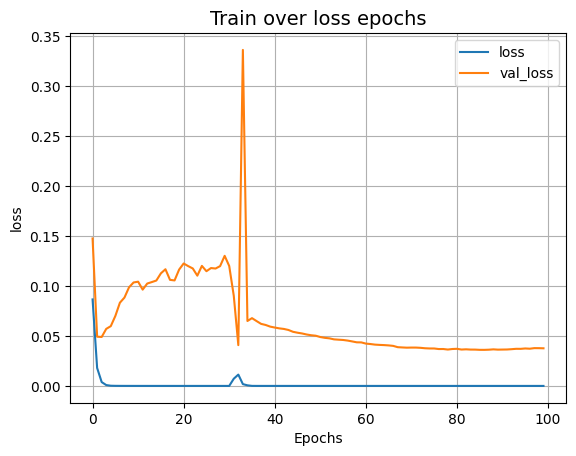

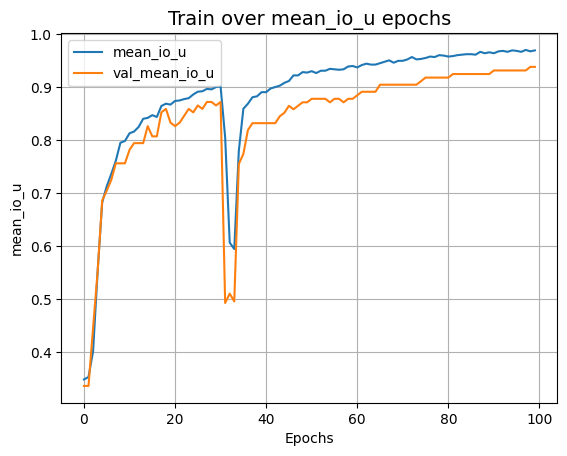

In [33]:
epochs = 100

callbacks = [
     ModelCheckpoint(check_path, monitor='val_mean_io_u', save_best_only=True, verbose=0),
]

history = model.fit(
    seq_train_df,
    params_train_df_multilabel,
    validation_data=(seq_test_df, params_test_df_multilabel),#add validation data                    
    epochs = epochs,
    batch_size=10,
    callbacks=callbacks,
    class_weight = {0: 0.3,
                1: 0.24,
                2: 1}
)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_"+item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train over {} epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("mean_io_u")

In [35]:
_, _, mean_io_u = model.evaluate(seq_test_df, params_test_df_multilabel)
print(f"Accuracy on the test set: {round(mean_io_u *100, 2)}%")

6/6 [==============================] - 0s 43ms/step - loss: 0.0376 - accuracy: 0.8160 - mean_io_u: 0.9382
Accuracy on the test set: 93.82%


In [34]:
model.save(check_path)

INFO:tensorflow:Assets written to: ./model-without-empty-param-checkpoints\assets


INFO:tensorflow:Assets written to: ./model-without-empty-param-checkpoints\assets


In [12]:
model = models.load_model(check_path)

In [37]:
def preprocess_text(line):
  tokenized_string = tokenizer_text.texts_to_sequences([line])
  padded_sequence = pad_sequences(tokenized_string, maxlen=max_text_len)
  return padded_sequence


In [43]:
test_string = preprocess_text("10Е9/л (1.70 - 7.60) Базофилы # (Bas) 0.04 10Е9/л (0.00 - 0.10) Эозинофилы # Лимфоциты # (lym)")
result = model.predict(tf.convert_to_tensor(test_string))
print(result)

1/1 [==============================] - 0s 26ms/step
[[2.387698e-17 9.810178e-01]]
